In [5]:
# Run in a notebook cell with `!` or in terminal.
!pip install pandas scikit-learn matplotlib wordcloud seaborn nltk tqdm

Defaulting to user installation because normal site-packages is not writeable


In [35]:
import pandas as pd


In [36]:
df=pd.read_csv("labeled_level1_labeled.csv")

In [37]:
df.head()

,from,sender_domain,clean_text,deadline_date,label_source,label_topic,label_urgency
0,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,request for email data contribution – research...,NaN,Misc,NaN,NaN
1,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,re: request for email data contribution – rese...,NaN,Misc,NaN,NaN
2,NPTEL <onlinecourses@nptel.iitm.ac.in>,nptel.iitm.ac.in,nptel newsletter: iit madras code certificate ...,NaN,NPTEL / External Courses,NaN,NaN
3,Team at Read <support@e.read.ai>,e.read.ai,exclusive education pricing just for you! read...,NaN,Misc,NaN,NaN
4,Mohini Darji <mohinidarji.dcs@charusat.ac.in>,charusat.ac.in,reg. submission of sgp- weekly reports dear st...,NaN,SGP / Project Related,NaN,NaN


                              count  percent
label_source                                
Misc                            592    38.59
Events / Hackathons / Clubs     333    21.71
Exam Cell / Academic Office     302    19.69
NPTEL / External Courses        140     9.13
Administrative                   68     4.43
SGP / Project Related            67     4.37
Internships / Placement Cell     32     2.09


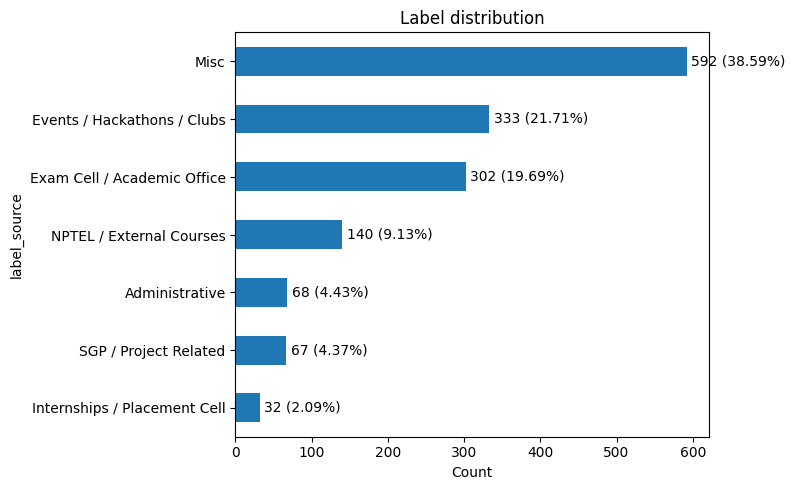

In [38]:
# show distribution of labels (counts + percentages) and plot a horizontal bar chart
label_series = df['label_source'].fillna('Unlabeled')
counts = label_series.value_counts()
percents = label_series.value_counts(normalize=True).mul(100).round(2)
dist = pd.concat([counts, percents], axis=1, keys=['count', 'percent'])
print(dist)

import matplotlib.pyplot as plt

counts_sorted = counts.sort_values(ascending=True)
plt.figure(figsize=(8, 5))
ax = counts_sorted.plot(kind='barh', color='C0')
plt.xlabel('Count')
plt.title('Label distribution')
# annotate counts on bars
for i, (idx, v) in enumerate(counts_sorted.items()):
    ax.text(v + max(counts_sorted) * 0.01, i, f"{v} ({dist.loc[idx,'percent']}%)", va='center')
plt.tight_layout()
plt.show()

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words='english'
)

X = vectorizer.fit_transform(df["clean_text"])
y = df["label_source"]


In [40]:
import numpy as np
from collections import defaultdict

label_vectors = defaultdict(list)

for vec, label in zip(X, y):
    label_vectors[label].append(vec)

label_centroids = {
    label: np.mean(np.vstack([v.toarray() for v in vecs]), axis=0)
    for label, vecs in label_vectors.items()
}


In [29]:
from sklearn.metrics.pairwise import cosine_similarity

labels = list(label_centroids.keys())

for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        sim = cosine_similarity(
            label_centroids[labels[i]].reshape(1, -1),
            label_centroids[labels[j]].reshape(1, -1)
        )[0][0]

        print(f"{labels[i]}  <->  {labels[j]}  =  {sim:.3f}")


Misc  <->  NPTEL / External Courses  =  0.154
Misc  <->  SGP / Project Related  =  0.798
Misc  <->  Exam Cell / Academic Office  =  0.806
Misc  <->  Events / Hackathons / Clubs  =  0.809
Misc  <->  Administrative  =  0.797
Misc  <->  Internships / Placement Cell  =  0.753
NPTEL / External Courses  <->  SGP / Project Related  =  0.067
NPTEL / External Courses  <->  Exam Cell / Academic Office  =  0.055
NPTEL / External Courses  <->  Events / Hackathons / Clubs  =  0.120
NPTEL / External Courses  <->  Administrative  =  0.064
NPTEL / External Courses  <->  Internships / Placement Cell  =  0.038
SGP / Project Related  <->  Exam Cell / Academic Office  =  0.827
SGP / Project Related  <->  Events / Hackathons / Clubs  =  0.822
SGP / Project Related  <->  Administrative  =  0.824
SGP / Project Related  <->  Internships / Placement Cell  =  0.784
Exam Cell / Academic Office  <->  Events / Hackathons / Clubs  =  0.764
Exam Cell / Academic Office  <->  Administrative  =  0.870
Exam Cell / Acade

In [41]:
for label in labels:
    vecs = np.vstack([v.toarray() for v in label_vectors[label]])
    sims = cosine_similarity(vecs)
    avg_sim = (np.sum(sims) - len(vecs)) / (len(vecs)**2 - len(vecs))
    print(f"{label}: internal similarity = {avg_sim:.3f}")


Misc: internal similarity = 0.064
NPTEL / External Courses: internal similarity = 0.196
SGP / Project Related: internal similarity = 0.168
Exam Cell / Academic Office: internal similarity = 0.181
Events / Hackathons / Clubs: internal similarity = 0.087
Administrative: internal similarity = 0.217
Internships / Placement Cell: internal similarity = 0.268


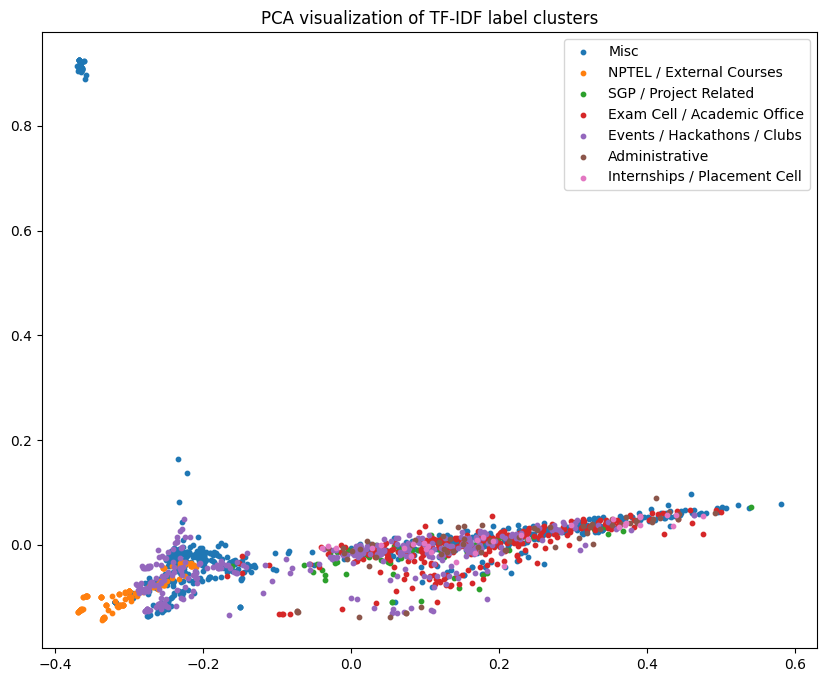

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_dense = X.toarray()

pca = PCA(n_components=2)
X2 = pca.fit_transform(X_dense)

plt.figure(figsize=(10,8))
for label in labels:
    idx = df["label_source"] == label
    plt.scatter(X2[idx,0], X2[idx,1], label=label, s=10)

plt.legend()
plt.title("PCA visualization of TF-IDF label clusters")
plt.show()


In [42]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('all-MiniLM-L6-v2')

emb = model.encode(df["clean_text"].tolist(), show_progress_bar=True)


ModuleNotFoundError: No module named 'sentence_transformers'

In [ ]:
# For every unique label_source, return 5 emails with their clean_text
unique_labels = df['label_source'].unique()

for label in unique_labels:
    print(f"Label: {label}")
    subset = df[df['label_source'] == label].head(5)
    for idx, row in subset.iterrows():
        print(f"Email {idx}: {row['clean_text']}")
    print("\n---\n")